In [94]:
%matplotlib notebook
import lightkurve as lk
import matplotlib.pyplot as plt
import scipy
lcflist = lk.search_lightcurvefile('KIC 7917485').download_all()

<IPython.core.display.Javascript object>


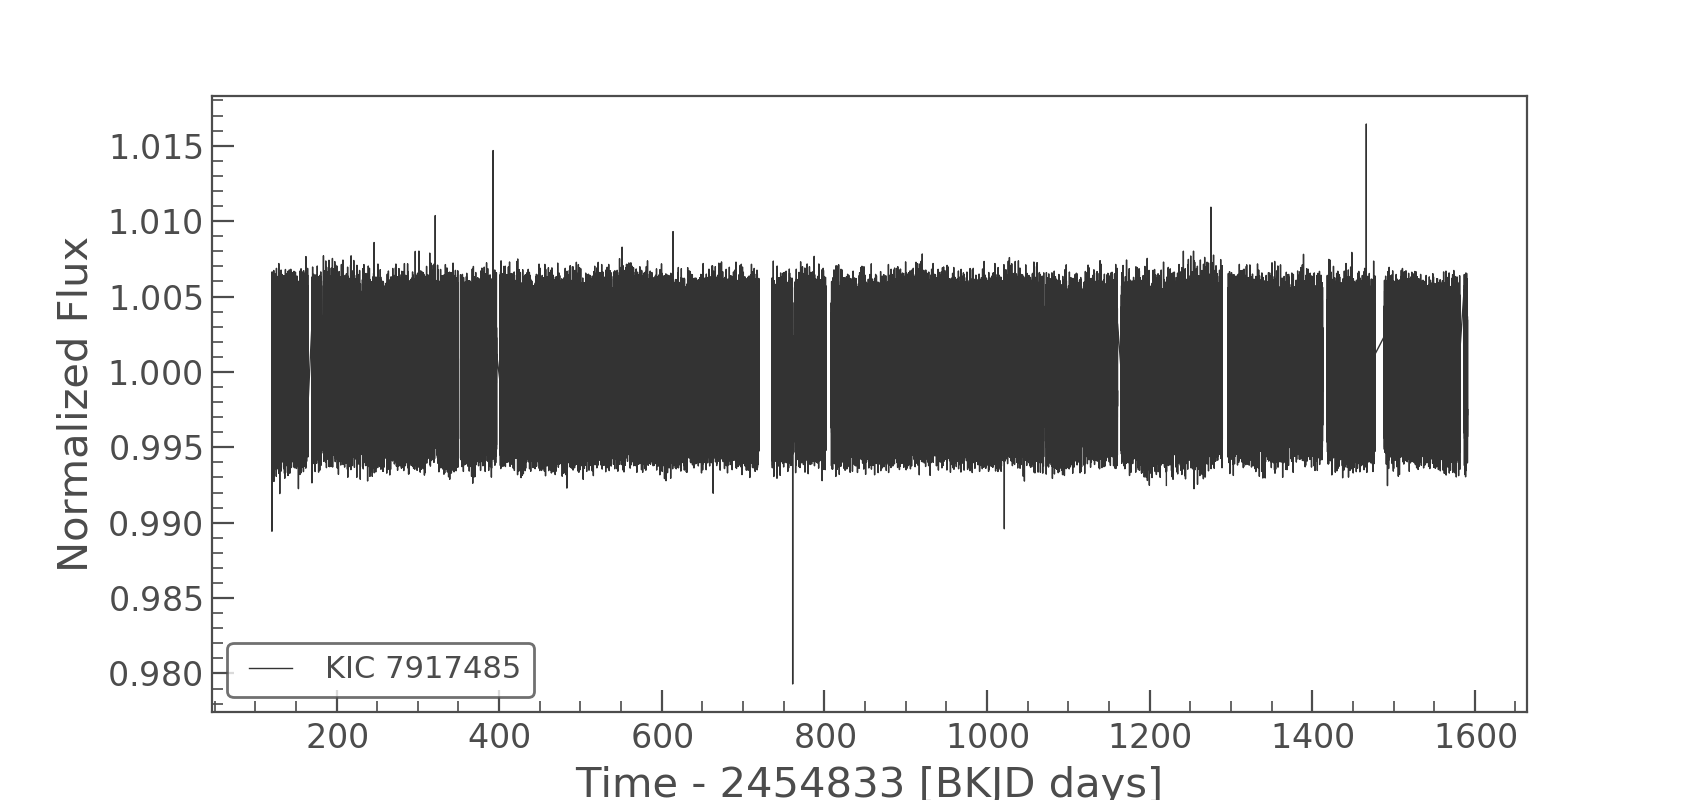

In [95]:
lc = lcflist[0].PDCSAP_FLUX.normalize().flatten(window_length=201,break_tolerance=10)
for value in lcflist[1:]:
    lc = lc.append(value.PDCSAP_FLUX.normalize().flatten(window_length=201,break_tolerance=10))
    
lc.plot()

<IPython.core.display.Javascript object>


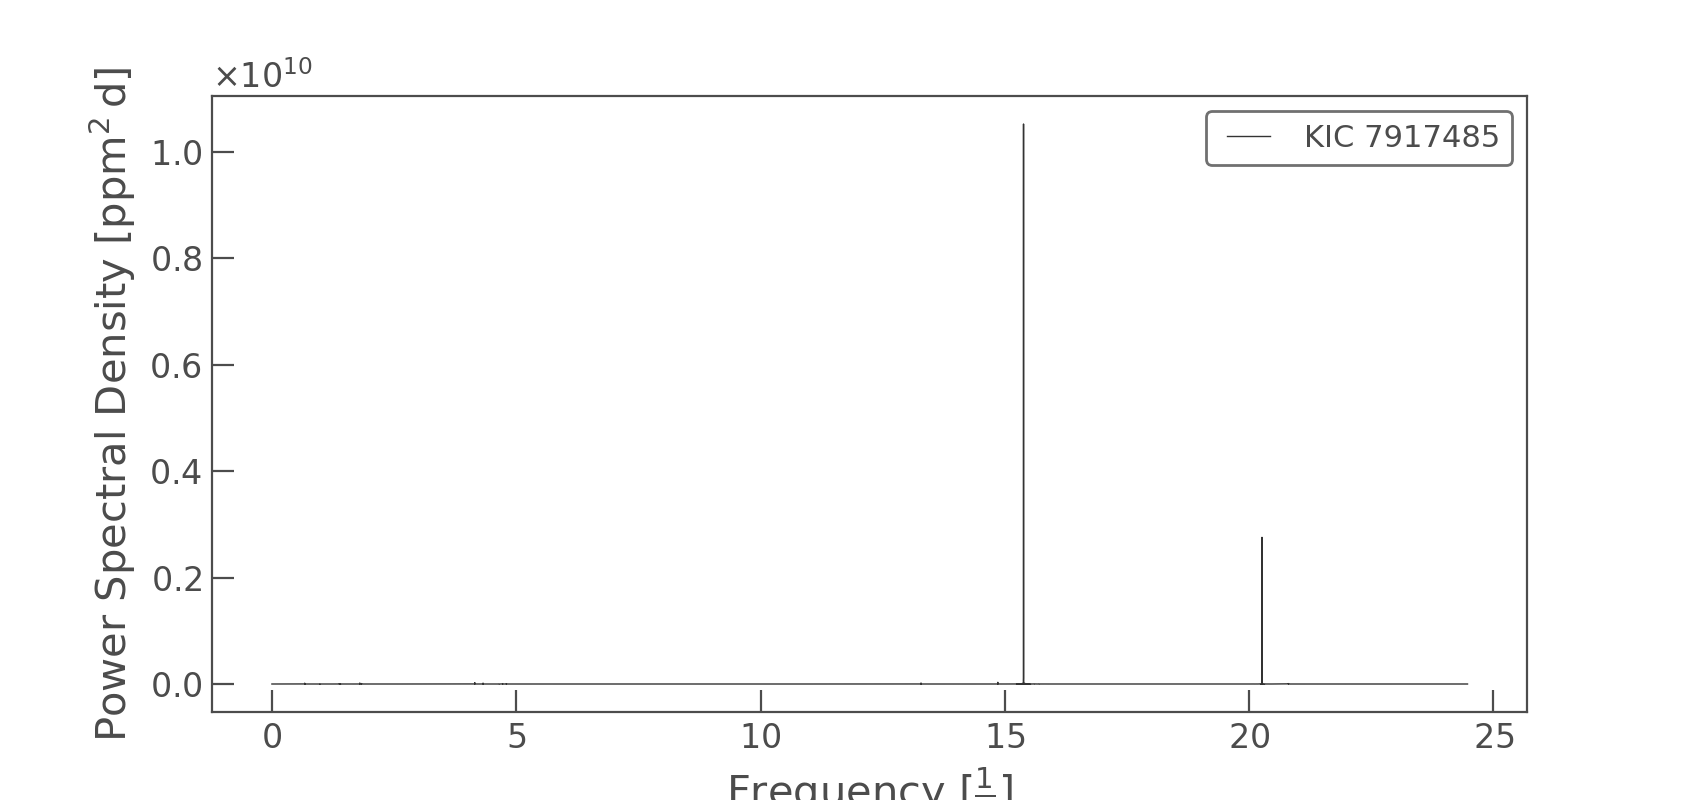

<IPython.core.display.Javascript object>


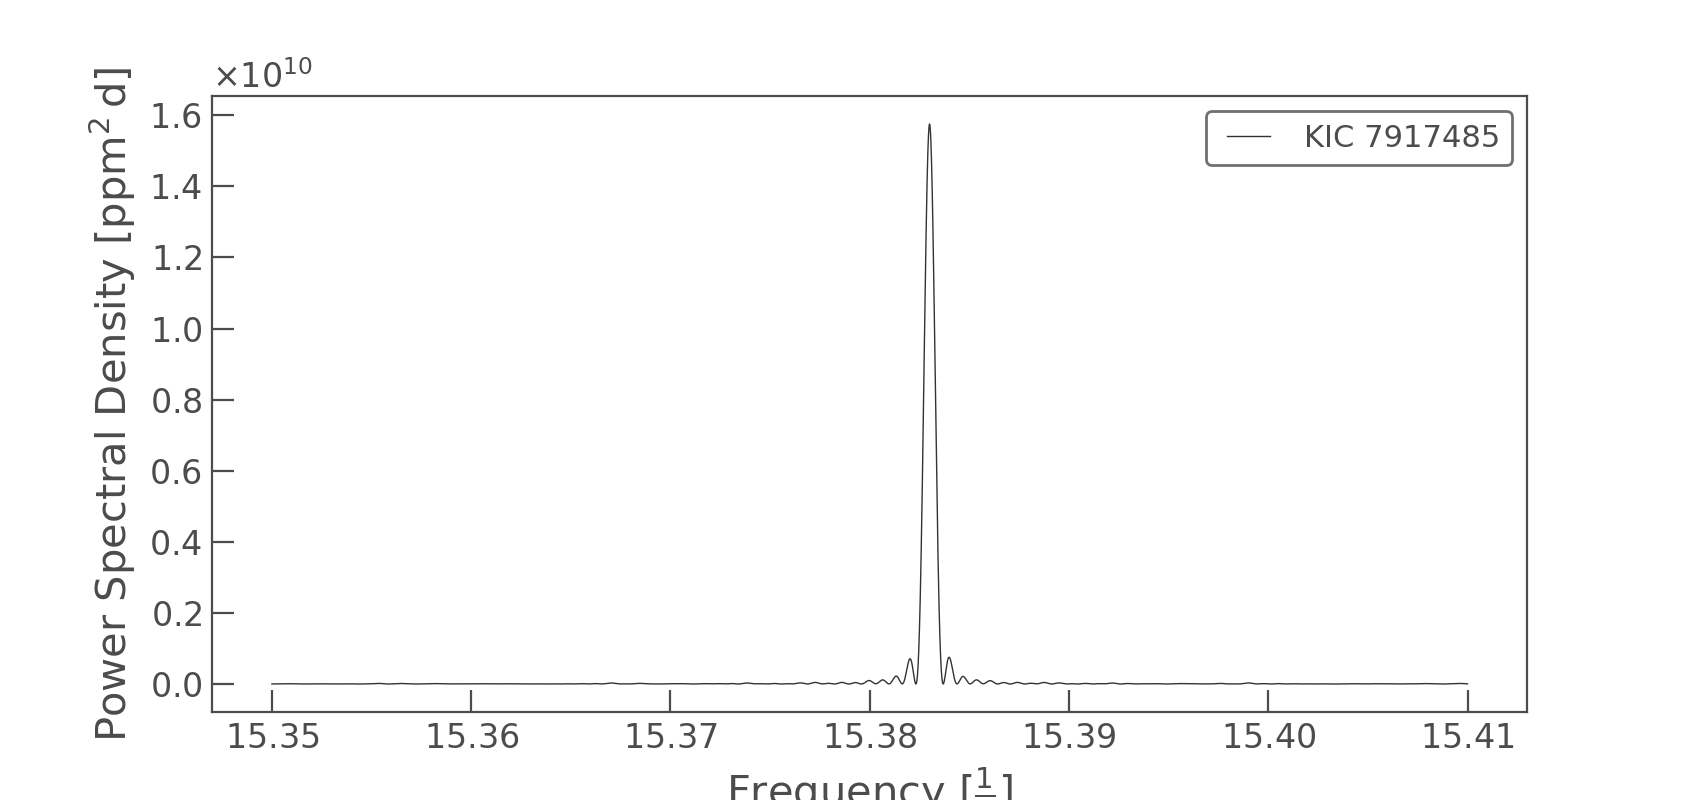

<IPython.core.display.Javascript object>


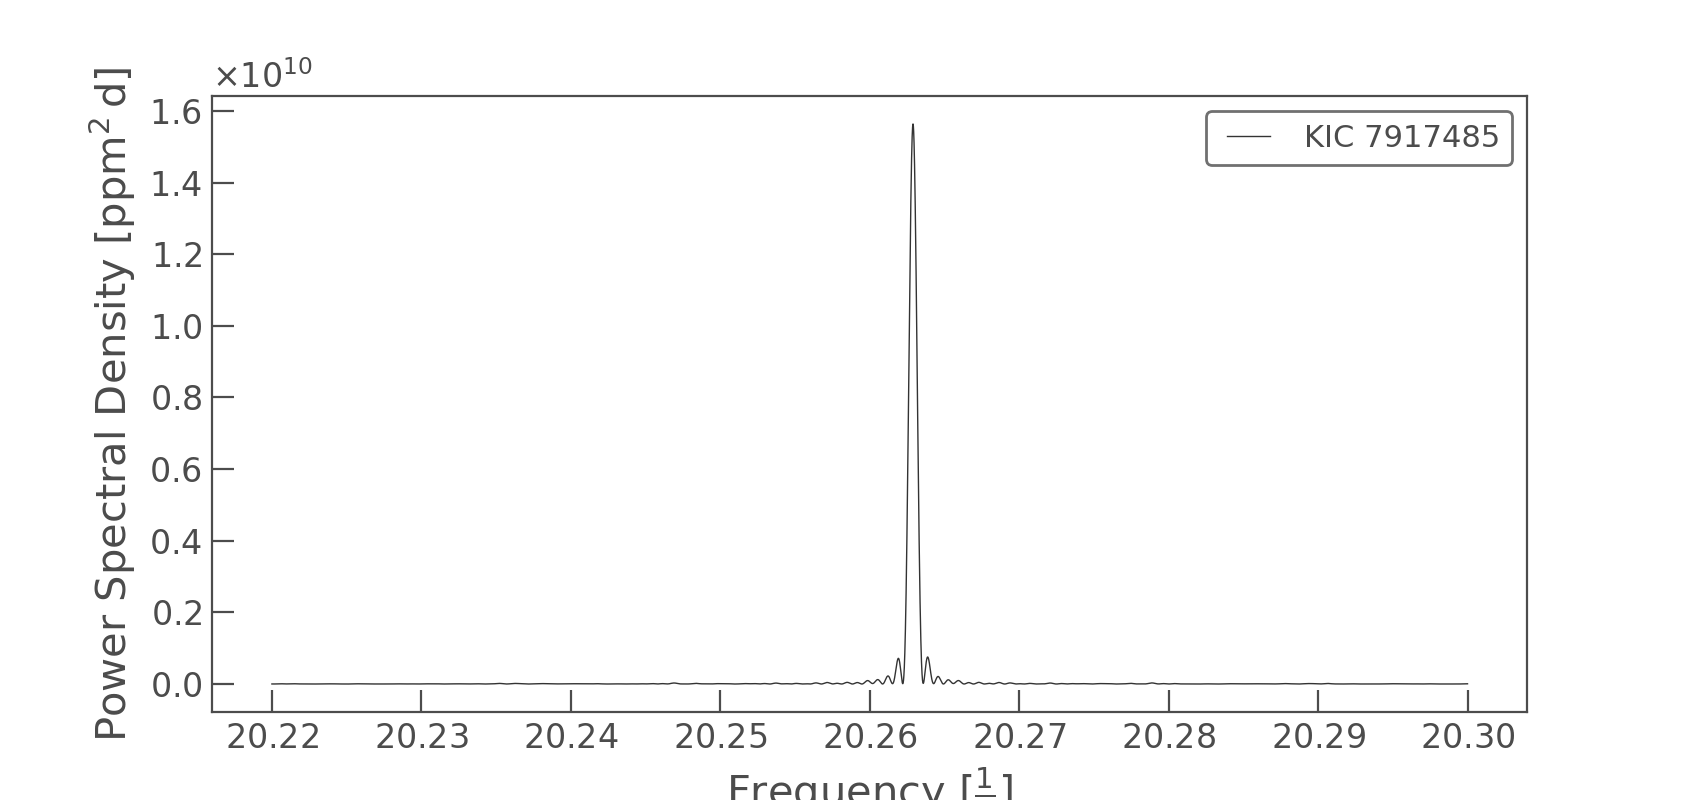

In [102]:
pg1 = lc.remove_nans().to_periodogram()
pg1.plot()
pg = lc.remove_nans().to_periodogram(min_frequency = 15.35, max_frequency = 15.41, oversample_factor = 500, nyquist_factor = 4)
pg.plot()
pg2 = lc.remove_nans().to_periodogram(min_frequency = 20.22, max_frequency = 20.3, oversample_factor = 500, nyquist_factor = 4)
pg2.plot()

<IPython.core.display.Javascript object>


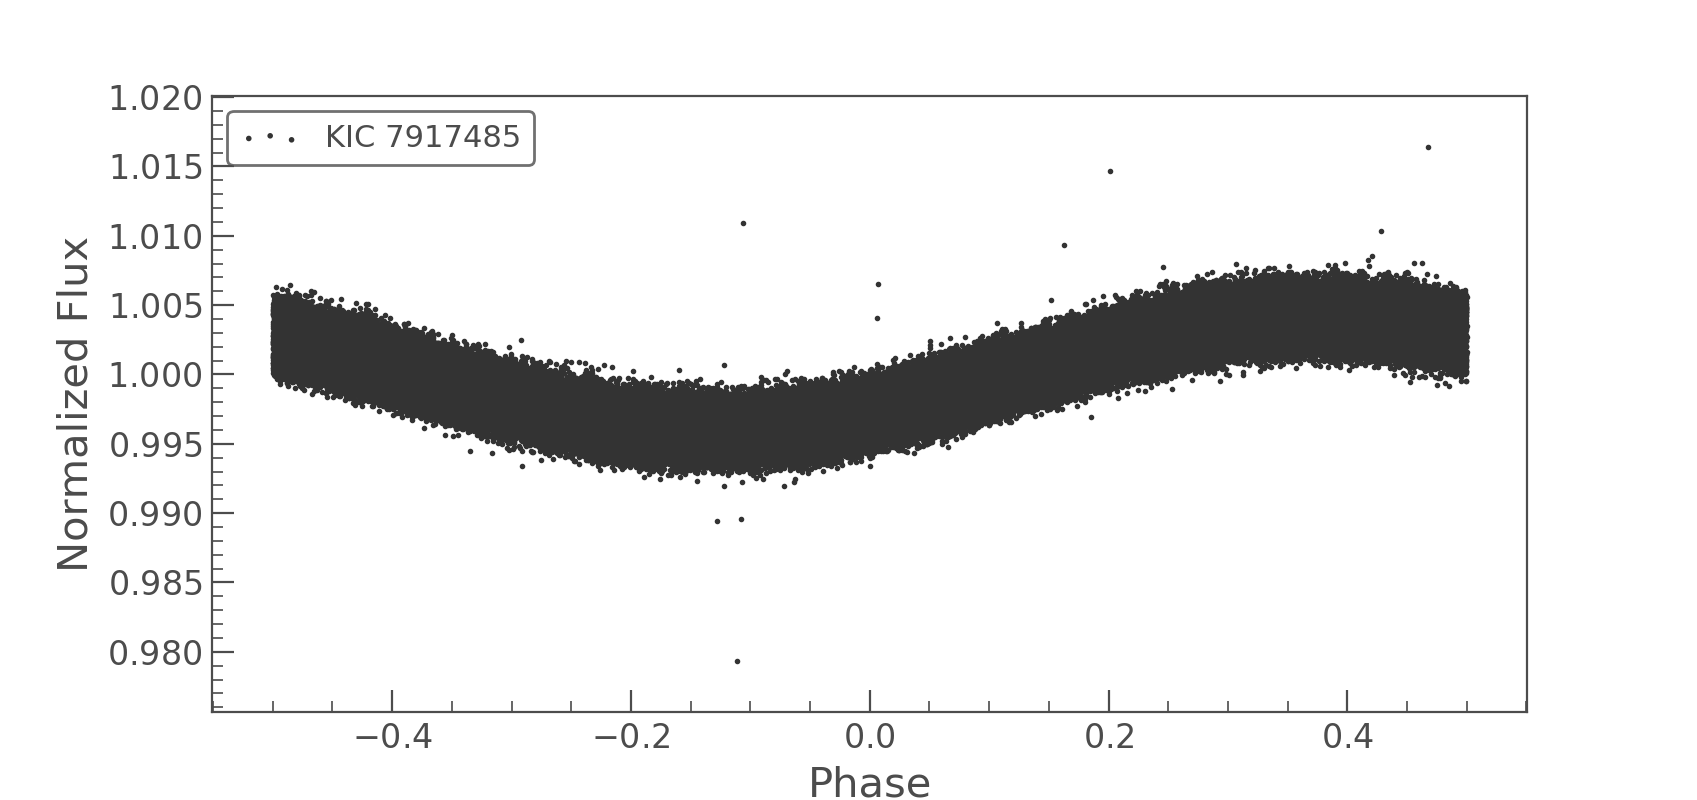

In [103]:
lc.fold(pg.period_at_max_power.value).scatter()
freq=pg.frequency_at_max_power.value

<IPython.core.display.Javascript object>


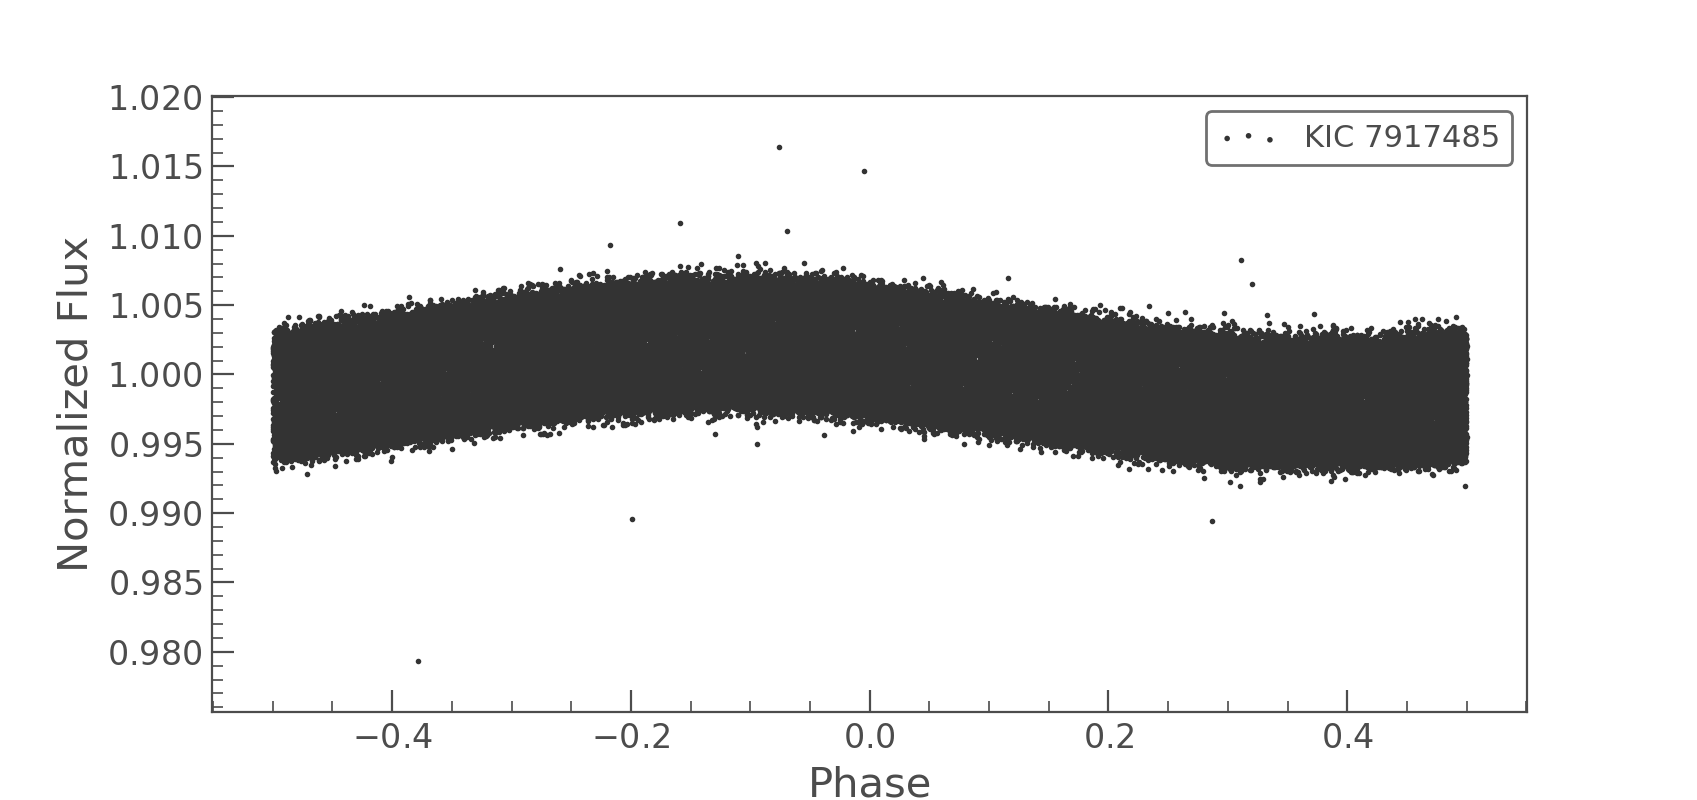

In [104]:
lc.fold(pg2.period_at_max_power.value).scatter()
freq2=pg2.frequency_at_max_power.value

In [105]:
def divide_chunks(l, n): 
  
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n]

In [106]:
def sinfunc(t,p, A):  return A * np.sin(2.*np.pi*freq*(t + p)) + 1.0
print(freq)

def sumofsins(t,p1,A1,p2,A2): return sinfunc(p1,A1)+sinfunc(p2,A2)

15.383003225651704


<IPython.core.display.Javascript object>


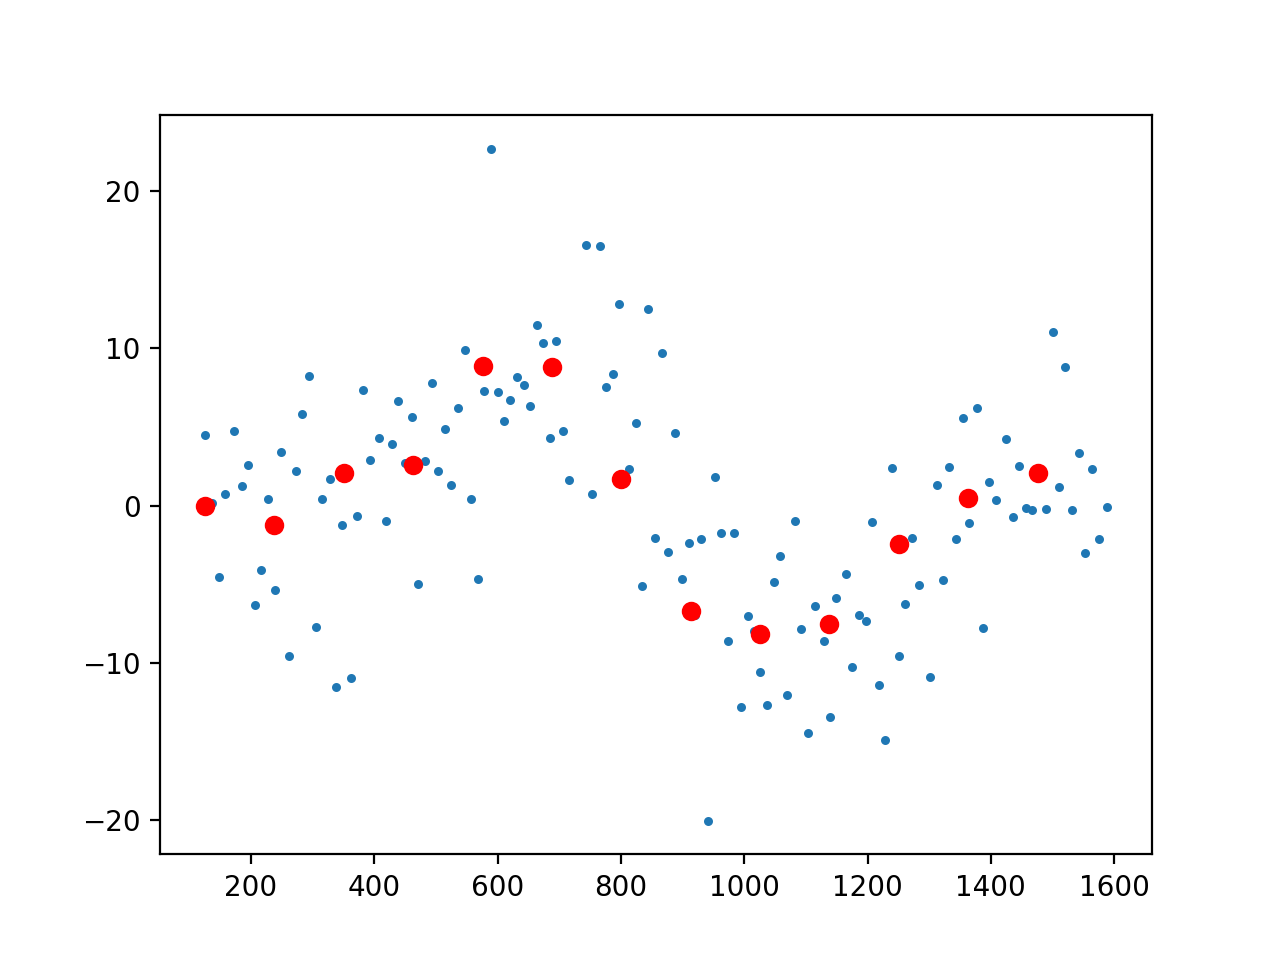

<Container object of 3 artists>

In [107]:
import numpy as np
lc = lc.remove_nans()
guess_amp = np.std(lc.flux) * 2.**0.5
num_sections = 500
time = list(divide_chunks(lc.time,num_sections))
flux = list(divide_chunks(lc.flux,num_sections))
import numpy as np
periodlist = []
mediantimelist = []
#iterate over every window
for index, interval in enumerate(time):
    guess = np.array([1325.31,guess_amp])
    popt, pcov = scipy.optimize.curve_fit(sinfunc, interval, flux[index], p0=guess)
    periodlist.append(popt[0])
    mediantimelist.append(np.median(interval))
fig = plt.figure()
ax = fig.add_subplot(111)

arr = scipy.stats.binned_statistic(mediantimelist, periodlist, 'mean', bins=13)
arr1 = scipy.stats.binned_statistic(mediantimelist, periodlist, np.std, bins=13)

ax.scatter(np.array(mediantimelist),86400*(np.array(periodlist)-np.mean(periodlist)),s=5)
ax.errorbar(arr[1][0:-1],(np.array(arr[0])-np.mean(periodlist))*86400,yerr = (arr1[0]*86400.0)/np.sqrt(arr[1][1]-arr[1][0]),fmt = 'o', c='red')

<IPython.core.display.Javascript object>


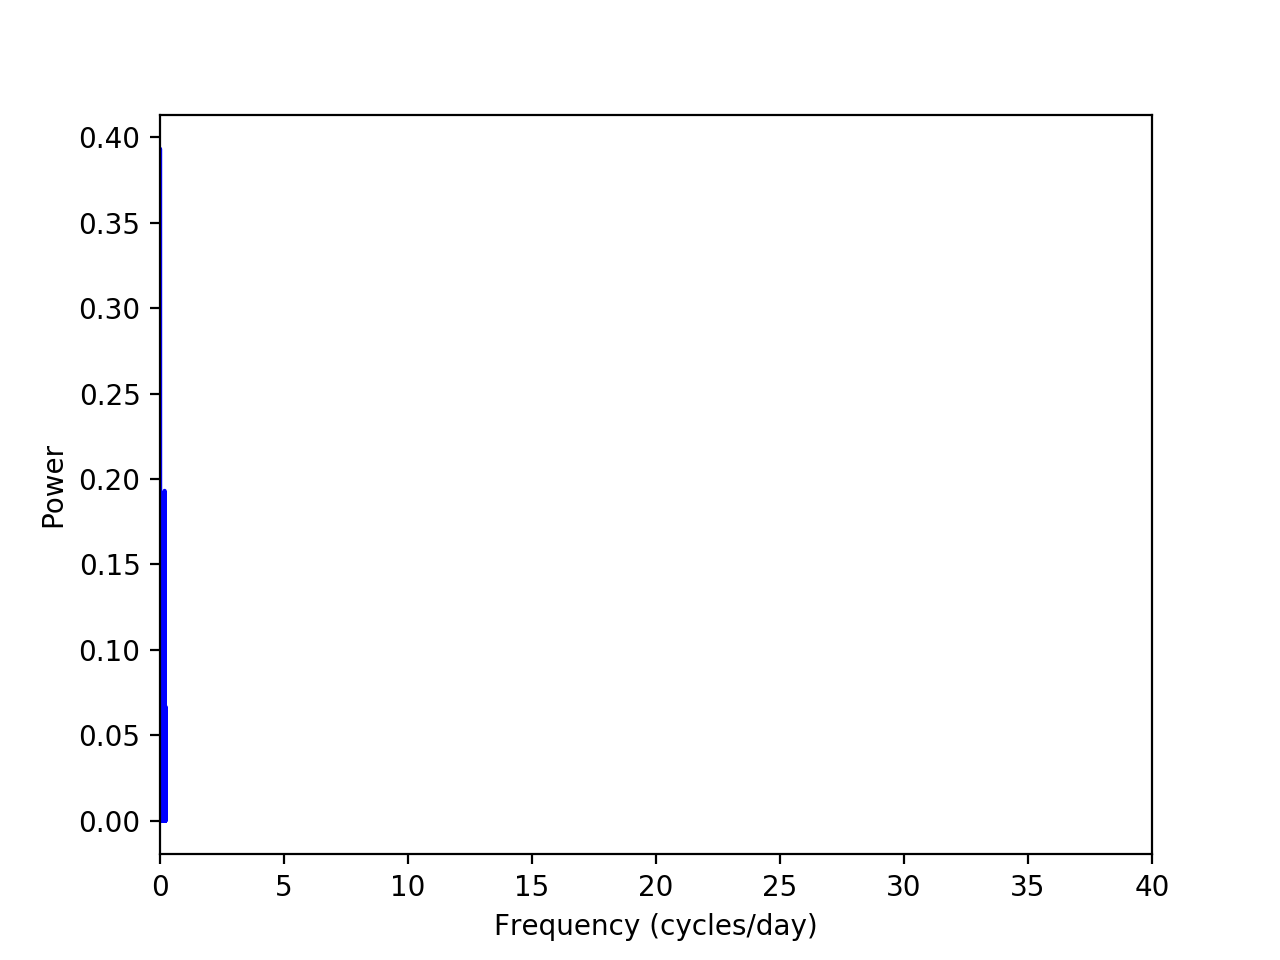

(0, 40)

In [108]:
%matplotlib notebook
from astropy.stats import LombScargle
frequency, power = LombScargle(np.array(mediantimelist),86400*(np.array(periodlist)-np.mean(periodlist))).autopower()
plt.clf()
plt.plot(frequency,power,c='blue')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power')
plt.xlim([0,40])

In [113]:
#BIC calculator
from lmfit import Model 
import math
def sine(x,t,b,a):
    return a*np.sin(2*(1/t)*math.pi*(x - b))
def line(x,m,c):
    return m*x + c
sinmodel = Model(sine)
params = sinmodel.make_params(t=840, b=450, a=5)
y = 86400*(np.array(periodlist)-np.mean(periodlist))
x = np.array(mediantimelist)
result = sinmodel.fit(y, params, x=x)
print(result.fit_report())

print()
linemodel = Model(line)
params1 = linemodel.make_params(m=0, c=0)
result1 = linemodel.fit(y, params1, x=x)
print(result1.fit_report())
if result.bic-result1.bic < 0.0:
    print("PTV found!")
else:
    print("No PTV detected")
print(result1.best_fit)
    
ax.scatter(np.array(mediantimelist),86400*(np.array(periodlist)-np.mean(periodlist)),s=5)
ax.errorbar(arr[1][0:-1],(np.array(arr[0])-np.mean(periodlist))*86400,yerr = (arr1[0]*86400.0)/np.sqrt(arr[1][1]-arr[1][0]),fmt = 'o', c='red')

[[Model]]
    Model(sine)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 131
    # variables        = 3
    chi-square         = 4095.73986
    reduced chi-square = 31.9979677
    Akaike info crit   = 456.968198
    Bayesian info crit = 465.593790
[[Variables]]
    t:  1103.00370 +/- 43.0659890 (3.90%) (init = 840)
    b:  322.404018 +/- 27.3286253 (8.48%) (init = 450)
    a:  6.69895995 +/- 0.73938467 (11.04%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(t, b) = -0.768
    C(t, a) =  0.112


[[Model]]
    Model(line)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 131
    # variables        = 2
    chi-square         = 6436.35928
    reduced chi-square = 49.8942580
    Akaike info crit   = 514.182252
    Bayesian info crit = 519.932647
[[Variables]]
    m: -0.00368516 +/- 0.00145714 (39.54%) (init = 0)
    c:  3.13796760 +/- 1.38578069 (44.16%) (

<Container object of 3 artists>